In [1]:
from fastai.text import *
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
import sentencepiece as spm
import re
import pdb

In [2]:
import fastai, torch
fastai.__version__ , torch.__version__

('1.0.57', '1.1.0')

In [3]:
torch.cuda.set_device(0)

In [5]:
!pwd

/home/gaurav/PycharmProjects/nlp-for-tamil/classification


In [6]:
path = Path('/home/gaurav/PycharmProjects/nlp-for-tamil/classification')

In [7]:
train_df = pd.read_csv(path/'train.csv')
train_df.head()

,text,label
0,ஏற்றுமதியை நம்பியுள்ள நாடுகளுக்குத்தான் இதனால்...,business
1,"* ""ரயிலில் தொங்கிக் கொண்டே சண்டையிடுவது போன்ற ...",tamil-cinema
2,"செளந்தர்ய லஹரி, லலிதா சகஸ்ரநாமம், சூக்தம், பூ...",spirituality
3,‘கடவுளே... என் சிவனே... எனக்கு நல்ல குருவை அட...,spirituality
4,'அப்பா' படம் வசனங்களாலேயே நகர்கிறது. காட்சிப்ப...,tamil-cinema


In [8]:
valid_df = pd.read_csv(path/'valid.csv')
valid_df.head()

,text,label
0,விழிப்புணர்வு நிகழ்ச்சிகள் காரணமாக சிறிய நகரங்...,business
1,இறைவனை விட இறைவனின் நாமமே சிறந்தது என்பார்கள் ...,spirituality
2,தொடர்ச்சியாக காதல் படங்களில் நடித்தீர்கள். காத...,tamil-cinema
3,மெரிக்க சந்தையில் சிறந்த வரவேற்பைப் பெற்றுவிட்...,business
4,பெரிய பதவியில் இருப்பவர்கள் அறிமுகமாவார்கள். ச...,spirituality


In [9]:
print('In Training data:')
for cls in train_df['label'].unique():
    print(cls, (train_df['label'] == cls).sum())

In Training data:
business 1552
tamil-cinema 2271
spirituality 1524


In [10]:
print('In Validation data:')
for cls in valid_df['label'].unique():
    print(cls, (valid_df['label'] == cls).sum())

In Validation data:
business 402
spirituality 380
tamil-cinema 555


In [12]:
train_df['text'][0]

'ஏற்றுமதியை நம்பியுள்ள நாடுகளுக்குத்தான் இதனால் பாதிப்பு. உள்நாட்டிலேயே தேவை அதிகமாக உள்ள இந்தியா போன்ற மக்கள் தொகை அதிகம் கொண்ட வளரும் பொருளாதார நாட்டில் பிரச்சினை ஏற்படாது என்று அவர் திட்டவட்டமாகக் கூறினார்.'

In [13]:
train_df.shape, valid_df.shape

((5347, 2), (1337, 2))

In [14]:
train_df[train_df['text'].isnull()].shape, valid_df[valid_df['text'].isnull()].shape

((0, 2), (0, 2))

In [24]:
class TamilTokenizer(BaseTokenizer):
    def __init__(self, lang:str):
        self.lang = lang
        self.sp = spm.SentencePieceProcessor()
        self.sp.Load(str(path/'../tokenizer/tamil_spm_8k.model'))
        
    def tokenizer(self, t:str) -> List[str]:
        return self.sp.EncodeAsPieces(t)

In [25]:
sp = spm.SentencePieceProcessor()
sp.Load(str(path/'../tokenizer/tamil_spm_8k.model'))
itos = [sp.IdToPiece(int(i)) for i in range(8000)]

In [26]:
tamil_vocab = Vocab(itos)

In [27]:
tokenizer = Tokenizer(tok_func=TamilTokenizer, lang='ta')

In [28]:
label_cols = [1]

In [29]:
data_lm = TextLMDataBunch.from_df(path=path, train_df=train_df, valid_df=valid_df, text_cols=[0], label_cols=label_cols, tokenizer=tokenizer, vocab=tamil_vocab, bs=16)

In [30]:
data_lm.save()

In [31]:
data_lm.show_batch()

idx,text
0,"▁பய மாக ▁இருக்கும் . ▁அவர் ▁மட்டுமன்றி ▁சண்டை ▁பயிற்சி யாளர்கள் ▁அனைவர ு மே ▁நிறைய ▁ரி ஸ் க் ▁எடுத்த ிருக்க ிறோம் "" ▁என்று ▁தெரிவித்தார் ▁சண்டை ப்ப யி ற் ச்சி ▁இயக்குநர் ▁ ஸ்ட ண்ட் ▁சி வா . ▁ x x b os ▁செ ள ந்தர் ய ▁ல ஹ ரி , ▁ல லி தா ▁சக ஸ் ர நாம ம் , ▁ <unk> சூ க் தம் , ▁பூ ▁சூ க் தம் , ▁நீள ா ▁சூ"
1,". ▁ x x b os ▁2005 - ம் ▁ஆண்டு ▁வெளிநாட்டு ▁குளிர் பா ன ▁விளம்பர ம் ▁ஒன்றில் ▁நடித்தார் ▁ரா தி கா . ▁அந்த ▁விளம்பர த்தை ▁எடுத்து , ▁ரா தி கா வை ▁கி ண்ட ல் ▁செய்யும் ▁தோ னி யில் ▁எ டி ட் ▁செய்து ▁வெளியிடப்பட்டது . ▁அந்த ▁வீடியோ ▁பதி வை ▁சமூக ▁வலை தள த்தில் ▁பலரும் ▁பகிர்ந்து ▁வந்தார் கள் . ▁ x x b os ▁இனி ▁இந்தக் ▁கா ரை ▁வாங்க ▁விரும்ப ுவோர் ▁சில"
2,"x b os ▁கரு மையான ▁குரோ மிய ▁பூ ச்சு ▁கொண்ட ▁முன்பு ற ▁கிரி ல் , ▁ஸ் டை லான ▁வடிவ த்தைக் ▁கொண்ட ▁முன்பு ற ▁ப ம்பர் , ▁அழகிய ▁உயர் ▁ ரக க் ▁கார் களில் ▁இடம்பெற ும் ▁பின்புற ▁விளக்கு , ▁உயர் வாக ▁அமைக்கப்பட்ட ▁பின்புற ▁எச்சரிக்கை ▁விளக்கு ▁ஆகியன ▁பி ரை யோ வின் ▁தோற்ற த்தை ▁முழுமையாக ▁மாற்ற ியுள்ளது . ▁ x x b os ▁ஐ ஏ என் ▁இன் கு பே ட்டர் , ▁வெ ன்"
3,"▁வாகன ம் ▁முதல் ▁கார் கள் ▁வரையிலான ▁விலை ▁குறை ப்பு ▁வாகன ▁பிரி யர்கள் ▁மத்தியில் ▁வரவேற்ப ைப் ▁பெற்றுள்ளது . ▁ x x b os ▁பழைய ன ▁கழி த லும் , ▁புதிய ன ▁புகு த லும் ▁புத்த ாண்ட ின் ▁முக்கிய ▁அம்ச மாகும் . ▁குறிப்பாக ▁தமிழர் ▁திரு நா ளா ம் ▁பொ ங்க லுக்கு ▁முந்தைய ▁போ கி ப் ▁பண்டிகை யை ▁பழைய ன ▁கழி தல் ▁முக்கிய ▁நிகழ்வ ாகவே ▁கருதப்படுகிறது . ▁ x x b os ▁இந்தியப்"
4,"மெ டி யாக ச் ▁சொல்ல ப்பட்ட ▁விஷ யம் , ▁மன தில் ▁பதி ந்த ிருக்கும் . ▁ஆனால் ▁இந்த ▁வார்த்தை ▁கா மெ டி ▁அல்ல . ▁வெறும் ▁விளையாட்டு ▁இல்லை . ▁ x x b os ▁அது ▁ஒரு ▁காலை ▁நேரம் . ▁ந பி களா ரின் ▁திருச்சபை யில் ▁ந பி த்தோ ழ ர்கள் ▁அமர்ந்த ிருக்க , ▁சிலர் ▁மு ர ட்டு க் ▁கம்ப ளி யைப் ▁போர் த்தி க்கொண்டு ▁அங்கு ▁வந்தார் கள் . ▁மு ள ர் ▁குல"


In [34]:
awd_lstm_config = awd_lstm_lm_config.copy()
awd_lstm_config['n_hid'] = 1150
learn = language_model_learner(data_lm, arch=AWD_LSTM, drop_mult=0.3, config=awd_lstm_config, pretrained=False)

In [35]:
learn.load('/home/gaurav/PycharmProjects/nlp-for-tamil/language-model/TamilWikiDataset/models/wikitalm_8k_447_third')

LanguageLearner(data=TextLMDataBunch;

Train: LabelList (5347 items)
x: LMTextList
▁ x x b os ▁ஏற்றுமதி யை ▁நம்பி யுள்ள ▁நாடுகளுக்கு த்தான் ▁இதனால் ▁பாதிப்பு . ▁உள் நாட்ட ிலேயே ▁தேவை ▁அதிகமாக ▁உள்ள ▁இந்தியா ▁போன்ற ▁மக்கள் ▁தொகை ▁அதிகம் ▁கொண்ட ▁வளரும் ▁பொருளாதார ▁நாட்டில் ▁பிரச்சினை ▁ஏற்பட ாது ▁என்று ▁அவர் ▁திட்ட வட்ட மாகக் ▁கூறினார் .,▁ x x b os ▁ <unk> ▁" ர யில ில் ▁தொங்க ிக் ▁கொண்டே ▁சண்டை யிட ுவது ▁போன்ற ▁காட்சி களில் ▁நடித்த ிருக்கிறார் ▁த னு ஷ் . ▁அதனை ப் ▁பார்க்க ும் ▁போது ▁பய மாக ▁இருக்கும் . ▁அவர் ▁மட்டுமன்றி ▁சண்டை ▁பயிற்சி யாளர்கள் ▁அனைவர ு மே ▁நிறைய ▁ரி ஸ் க் ▁எடுத்த ிருக்க ிறோம் " ▁என்று ▁தெரிவித்தார் ▁சண்டை ப்ப யி ற் ச்சி ▁இயக்குநர் ▁ ஸ்ட ண்ட் ▁சி வா .,▁ x x b os ▁செ ள ந்தர் ய ▁ல ஹ ரி , ▁ல லி தா ▁சக ஸ் ர நாம ம் , ▁ <unk> சூ க் தம் , ▁பூ ▁சூ க் தம் , ▁நீள ா ▁சூ க் தம் , ▁இந்திர ன் ▁கூறிய ▁மகா ல ஷ் மி ▁அ ஷ்ட கம் , ▁ஆதி சங்க ர ர் ▁அருள ிய ▁மகா ல ஷ் மி ▁ஸ் தோ த்திரம் ▁ஆகியவற்றில் ▁இ ய ன்ற தை ▁இல்ல த்தா ரே ▁சொல்ல லாம் . ▁மேலும் ▁இதனை ச் ▁சொல்ல ▁வல்ல ார ைக் ▁கொண்டு ▁இல்ல த்தில் 

In [36]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


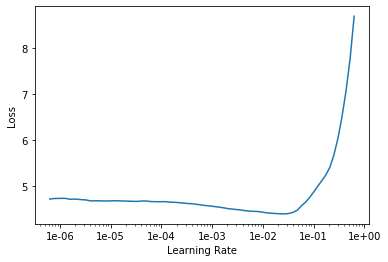

In [37]:
learn.recorder.plot()

In [38]:
learn.freeze()

In [39]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,3.911180,3.780526,0.361059,00:15


In [40]:
learn.unfreeze()

In [41]:
learn.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.526932,3.618111,0.378430,00:18
1,3.346618,3.495475,0.394815,00:18
2,3.077790,3.451136,0.402021,00:18
3,2.867625,3.447613,0.405216,00:18
4,2.780879,3.457287,0.405059,00:18


In [42]:
learn.predict('▁தனது ▁சொந்த',n_words=10)

'▁தனது ▁சொந்த ▁ஊரில் ▁படை ய ெடுக்க ிற ங்கிய ▁ஹரி ப் ப ரும்'

In [43]:
learn.save_encoder('fine_tuned_enc')

In [44]:
data_clas = TextClasDataBunch.from_df(path=path, train_df=train_df, valid_df=valid_df, tokenizer=tokenizer, vocab=tamil_vocab, text_cols=[0], label_cols=label_cols, bs=16)

In [45]:
data_clas.show_batch()

text,target
"▁ x x b os ▁நடிகர் ▁ச சி குமார் ▁மிகவும் ▁சிறந்த ▁இயக்குநர் ▁மற்றும் ▁நல்ல ▁மனிதர் . ▁அவரது ▁உறவினர் ▁அ சோ க்கு மர் ▁தற்கொலை யை ▁நினைத்த ு ▁நான் ▁மிகவும் ▁மன வே தனை ப்படுகிற ேன் . ▁அசோக ் குமார் ▁தனது ▁மனைவி , ▁பெற்றோர் ▁மற்றும் ▁குழந்தை களை ▁தவ ிக்க விட்டு விட்டு ▁தற்கொலை ▁செய்யும் ▁முடி வை ▁தவிர ் த்த ிருக்க ▁வேண்டும் . ▁ ta m il - c ine ma | ந டி கை",tamil-cinema
"▁ x x b os ▁இந்தியாவில் ▁புதிய ▁வரி ▁முறையான ▁ஜி எஸ் டி ▁அ மல் படுத்த ப்பட்டது ▁மிகப்பெரிய ▁பொருளாதார ▁மாற ுதலை ▁ஏற்படுத்திய ுள்ளது . ▁இதனால் ▁உடனடியாக ▁சில ▁பாதிப்பு கள் ▁இருந்தன . ▁பொருளாதார ▁வளர்ச்சி ▁விகிதம் ▁குறை யும் ▁என்ற ▁எதிர் பார் ப்பு ▁இருந்தது . ▁b us in ess | ந ட ப்பு ▁நிதி யா ண்டி ல் ▁பொருளாதார ▁வளர்ச்சி ▁6 . 5 ▁சதவீத மாக ▁இருக்கும் ▁என ▁இந்திய ▁அரசு ▁மதிப்ப ிட்ட ுள்ளது . ▁ஆனால் ,",business
"▁ x x b os ▁குரு ப க வான் ▁தன் ▁சுய ▁நட்சத்திர மான ▁விசாக ம் ▁1, ▁2, ▁3 - ம் ▁பாத ம் ▁து லாம் ▁ரா சி யிலேயே ▁ 08 . 12 . 20 17 ▁முதல் ▁13 . 02 . 20 18 ▁மற்றும் ▁ 04 . 07 . 20 18 ▁முதல் ▁ 02 . 10 . 20 18 ▁வரை ▁பயணி ப்ப தால் ▁கவு ர வ க் ▁குறைவான ▁சம்பவ ங்கள் ▁நிகழ க்கூடும்",spirituality
"▁ x x b os ▁ர ஜி னி யின் ▁ ட் விட்ட ர் ▁ஐ டி , ▁ <unk> s up ers ta r ra j in i ▁என ▁இருந்தது . ▁தற்போது ▁அதில் ▁உள்ள ▁சூப்பர் ▁ஸ்டா ரை த் ▁தூக்கி விட்டு ▁ர ஜி னி காந்த ் ▁என ▁மாற்ற ப்பட்ட ிருக்கிறது . ▁அதாவது , ▁ <unk> ra j in ik an th ▁என்று ▁மாற்ற ிய ிருக்கின்றன ர் . ▁இரண்டு ▁நாட்களுக்கு ▁முன்னர் ▁இன் ஸ்டா",tamil-cinema
"▁ x x b os ▁பெ ட்ரோ ல் ▁மாட ல் ▁15 ▁அங்கு ல ▁அ லாய் ▁சக்கர ங்களையும் , ▁டீ சல் ▁மாட ல் ▁14 ▁அங்கு ல ▁அ லாய் ▁சக்கர ங்களையும் ▁கொண்டுள்ளது . ▁கா ரின் ▁நீளம் ▁3, 99 2 ▁மி . மீ , ▁அகல ம் ▁1, 6 77 ▁மி . மீ , ▁உயரம் ▁1, 5 37 ▁மி . மீ . ▁சக்கர த்தின் ▁அகல ம் ▁2, 4 50 ▁மி . மீ யாகவும் ,",business


In [46]:
del awd_lstm_config['tie_weights']
del awd_lstm_config['out_bias']

In [47]:
learn = text_classifier_learner(data_clas, arch=AWD_LSTM, drop_mult=0.5, config=awd_lstm_config)

In [48]:
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (5347 items)
x: TextList
▁ x x b os ▁ஏற்றுமதி யை ▁நம்பி யுள்ள ▁நாடுகளுக்கு த்தான் ▁இதனால் ▁பாதிப்பு . ▁உள் நாட்ட ிலேயே ▁தேவை ▁அதிகமாக ▁உள்ள ▁இந்தியா ▁போன்ற ▁மக்கள் ▁தொகை ▁அதிகம் ▁கொண்ட ▁வளரும் ▁பொருளாதார ▁நாட்டில் ▁பிரச்சினை ▁ஏற்பட ாது ▁என்று ▁அவர் ▁திட்ட வட்ட மாகக் ▁கூறினார் .,▁ x x b os ▁ <unk> ▁" ர யில ில் ▁தொங்க ிக் ▁கொண்டே ▁சண்டை யிட ுவது ▁போன்ற ▁காட்சி களில் ▁நடித்த ிருக்கிறார் ▁த னு ஷ் . ▁அதனை ப் ▁பார்க்க ும் ▁போது ▁பய மாக ▁இருக்கும் . ▁அவர் ▁மட்டுமன்றி ▁சண்டை ▁பயிற்சி யாளர்கள் ▁அனைவர ு மே ▁நிறைய ▁ரி ஸ் க் ▁எடுத்த ிருக்க ிறோம் " ▁என்று ▁தெரிவித்தார் ▁சண்டை ப்ப யி ற் ச்சி ▁இயக்குநர் ▁ ஸ்ட ண்ட் ▁சி வா .,▁ x x b os ▁செ ள ந்தர் ய ▁ல ஹ ரி , ▁ல லி தா ▁சக ஸ் ர நாம ம் , ▁ <unk> சூ க் தம் , ▁பூ ▁சூ க் தம் , ▁நீள ா ▁சூ க் தம் , ▁இந்திர ன் ▁கூறிய ▁மகா ல ஷ் மி ▁அ ஷ்ட கம் , ▁ஆதி சங்க ர ர் ▁அருள ிய ▁மகா ல ஷ் மி ▁ஸ் தோ த்திரம் ▁ஆகியவற்றில் ▁இ ய ன்ற தை ▁இல்ல த்தா ரே ▁சொல்ல லாம் . ▁மேலும் ▁இதனை ச் ▁சொல்ல ▁வல்ல ார ைக் ▁கொண்டு ▁இல்ல த்தில் ▁பா ர

In [49]:
learn.freeze()

In [50]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


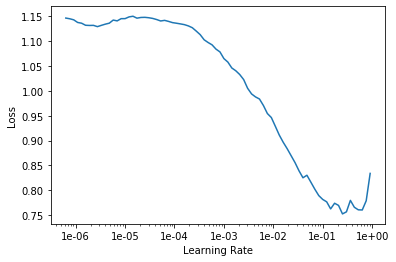

In [51]:
learn.recorder.plot()

In [52]:
learn.loss_func.func

CrossEntropyLoss()

In [53]:
kappa = KappaScore()

In [54]:
learn.metrics = [kappa, accuracy]

In [55]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.285563,0.167643,0.907482,0.939417,00:17


In [56]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.196215,0.125699,0.938551,0.959611,00:18


In [57]:
learn.unfreeze()
learn.fit_one_cycle(5, 1e-3, callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='accuracy', name='final')])

epoch,train_loss,valid_loss,kappa_score,accuracy,time
0,0.127554,0.118773,0.930402,0.954375,00:26
1,0.099802,0.102559,0.941894,0.961855,00:26
2,0.100311,0.098860,0.945176,0.964099,00:27
3,0.081874,0.121290,0.933662,0.956619,00:27
4,0.051257,0.095735,0.950926,0.967838,00:26


Better model found at epoch 0 with accuracy value: 0.9543754458427429.
Better model found at epoch 1 with accuracy value: 0.961854875087738.
Better model found at epoch 2 with accuracy value: 0.9640987515449524.
Better model found at epoch 4 with accuracy value: 0.96783846616745.


In [58]:
learn.predict('திருக்காஞ்சியில் ஸ்ரீ கங்கைவராக நதீஸ்வரர் ஆலயம் அமைந்துள்ளது.')[0]

Category spirituality

In [59]:
learn.predict('கீழ்த்திசை ஞானியர் குழந்தை இயேசுவைக் கண்டு வணங்கிய நிகழ்வை')[0]

Category spirituality

In [60]:
learn.predict("தர்காவுக்கு அருகிலேயே ஒரு பள்ளிவாசல் இருக்கிறது. உள்ளூர் மக்களும், தர்காவுக்கு வரும் வெளியூர் அன்பர்களும் அங்கு தொழுகிறார்கள்.")[0]

Category spirituality

In [61]:
learn.predict('இப்படத்தில் இன்னொரு நாயகனாக நாகார்ஜூனா நடிக்கவிருக்கிறார் என்றவுடன் உடனே இப்படத்தை ஒப்புக் கொண்டேன். அவருடைய பெரிய ரசிகன் நான்')[0]

Category tamil-cinema

In [62]:
learn.predict('ஒரு தொலைக்காட்சியில் ஒரு நடிகை தன்னுடைய நாடகங்களில் நடிக்கிறார் என்றால், மற்ற தொலைக்காட்சியில் நடிக்கக் கூடாது, ஷோவிற்கு போகக் கூடாது என்று கையெழுத்து வாங்கிக் கொள்கிறார்கள்.')[0]

Category tamil-cinema

In [63]:
learn.predict('இயக்குநர் ஷங்கர் - ரஜினிகாந்த் இணையின் 2.0 படத்தின் படப்பிடிப்பு மும்முரமாக நடைபெற்றுவருகிறது.')[0]

Category tamil-cinema

In [64]:
learn.predict('அருகில் இருங்காட்டுக் கோட்டையில் செயல்படும் ஹூண்டாய் நிறுவனம் இது போன்ற ஹீட் அலவன்ஸை பணியாளர்களுக்கு அளிக்கிறது. ஊழியர்கள் விடுத்த கோரிக்கையை ரெனால்ட் நிசான் நிர்வாகம் பரிசீலித்து வருவதாகத் தெரிகிறது.')[0]

Category business

In [65]:
learn.predict('சர்வதேச சந்தையில் கச்சா எண்ணெய் விலை அதிகரித்து வருவதால் முதலீட்டாளர்கள் கவனம் அதன் பக்கம் திரும்பியுள்ளது.')[0]

Category business

In [66]:
learn.predict('மேடிசன் ஸ்போர்ட்ஸ் குழுமத்தின் இயக்குநர் பொறுப்பில் இருந்தவர். இன்ச்கேப் நிறுவனத்தின் பொறுப்புகள் அல்லாத இயக்குநர் பொறுப்பில் இருந்தவர்.')[0]

Category business